## Import Packages

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # Memory allocation
import keras
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random
import os
import sys

# Memory Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Using TensorFlow backend.
1 Physical GPUs, 1 Logical GPUs


## Load Dataset
    - Wild한 상황에 대비한 easy, medium, hard 변화 이미지

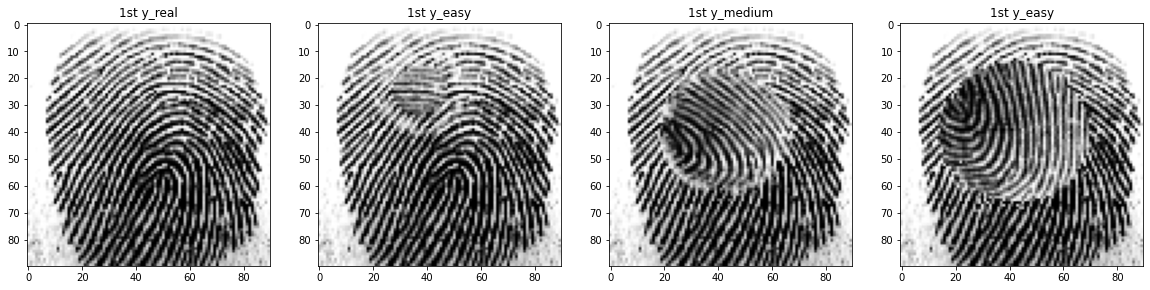

In [2]:
RUN_BASE_PATH = os.path.abspath("./")
DATA_BASE_PATH = os.path.abspath("../../00_MLDL/00_BreadBrother/03_Fingerprint_Recognition")
#sys.path.append(DATA_BASE_PATH)
#print(sys.path)


x_real = np.load(os.path.join(DATA_BASE_PATH, "dataset\\x_real.npz"))["data"] # 6000,90,90,1
y_real = np.load(os.path.join(DATA_BASE_PATH, "dataset\\y_real.npy")) # 6000,4

x_easy = np.load(os.path.join(DATA_BASE_PATH, "dataset\\x_easy.npz"))["data"] # 17931, 90, 90, 1
y_easy = np.load(os.path.join(DATA_BASE_PATH, "dataset\\y_easy.npy")) # 17931, 4

x_medium = np.load(os.path.join(DATA_BASE_PATH, "dataset\\x_medium.npz"))["data"] # 17067, 90, 90, 1
y_medium = np.load(os.path.join(DATA_BASE_PATH, "dataset\\y_medium.npy")) # 17067, 4

x_hard = np.load(os.path.join(DATA_BASE_PATH, "dataset\\x_hard.npz"))["data"] # 14272, 90, 90, 1
y_hard = np.load(os.path.join(DATA_BASE_PATH, "dataset\\y_hard.npy")) # 14272, 4

plt.figure(figsize = (20, 15))
plt.subplot(1,4,1)
plt.title("1st y_real")
plt.imshow(x_real[0].squeeze(), cmap="gray")

plt.subplot(1,4,2)
plt.title("1st y_easy")
plt.imshow(x_easy[0].squeeze(), cmap="gray")

plt.subplot(1,4,3)
plt.title("1st y_medium")
plt.imshow(x_medium[0].squeeze(), cmap="gray")

plt.subplot(1,4,4)
plt.title("1st y_easy")
plt.imshow(x_hard[0].squeeze(), cmap="gray")

## Train Test Split

In [3]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0) # 49270, 90, 90, 1
label_data = np.concatenate([y_easy, y_medium, y_hard], axis=0) # 49270, 4

x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size = 0.1) # Train 44343, Validation 4927, Total 49270

print(f"Total data / label shape : {x_data.shape} {label_data.shape}")
print(f"Training data / label shape : {x_train.shape} {label_train.shape}")
print(f"Validation data / label shape : {x_val.shape} {label_val.shape}")


Total data / label shape : (49270, 90, 90, 1) (49270, 4)
Training data / label shape : (44343, 90, 90, 1) (44343, 4)
Validation data / label shape : (4927, 90, 90, 1) (4927, 4)


## Preview Augmentation
    - Test

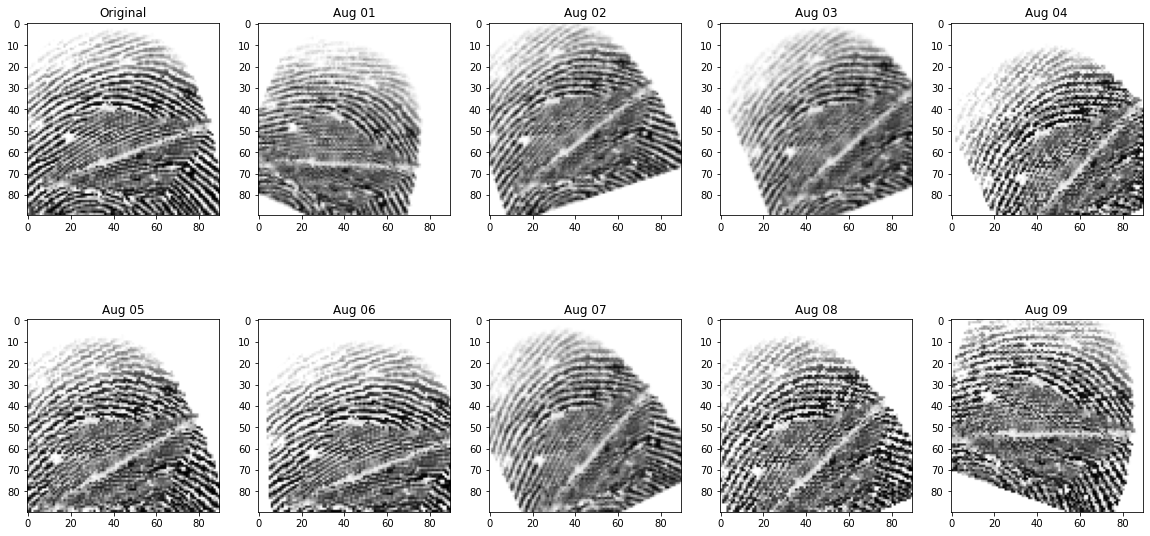

In [4]:
augs = [x_data[40000]]*9 # 40000th data 9-copies 

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        # scale images to 90-110% of their size, individually per axis
        scale = {"x" : (0.9, 1.1), "y" : (0.9, 1.1)},
        # translate by -10 to +10 percent (per axis)
        translate_percent = {"x" : (-0.1, 0.1), "y" : (-0.1, 0.1)},
        # rotate by -30 to +30 degrees
        rotate = (-30, 30),
        # use nearest neighbour or bilinear interpolation (fast)
        order = [0, 1],
        # if mode is constant, use a cval between 0 and 255
        # 빈공간 채우기
        cval = 255
    )
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize = (20, 10))
plt.subplot(2,5,1)
plt.title("Original")
plt.imshow(x_data[40000].squeeze(), cmap="gray")
for i, aug in enumerate(augs):
    plt.subplot(2,5,i+2)
    plt.title(f"Aug {i+1:02d}")
    plt.imshow(aug.squeeze(), cmap="gray")

## Make Label Dictionary LUT(from MSB)
    - subject_id(3)
    - gender(1) : 0(male) / 1(female)
    - left of right(1) : 0(left) / 1(right)
    - finger index(1) : 0(thumb) / 1(index) / 2(middle) / 3(ring) / 4(little)

In [5]:
label_real_dict = {}
for i, y in enumerate(y_real):
    key = y.astype(str) # change type
    key = ''.join(key).zfill(6) # link strings from LSB

    label_real_dict[key] = i

print(y_real[0]) # id(3), gender, leftright, finger

[100   0   0   1]


## Data Generator

In [6]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        '''
        Initialization
        '''
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return int(np.floor(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        x1_batch = self.x[index * self.batch_size : (index+1) * self.batch_size] # batch size
        label_batch = self.label[index * self.batch_size : (index+1) * self.batch_size] # batch size

        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        # Augmentaiton
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)

        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        # matched images must be all same, [subject_id(3), gender(1), left_right(1), finger(1)], e.g) 034010
        for i, l in enumerate(label_batch):
            match_key = l.astype(str)
            match_key = ''.join(match_key).zfill(6)

            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]]
                y_batch[i] = 1.
            else:
                # put unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))

                    if unmatch_key != match_key:
                        break

                x2_batch[i] = self.x_real[unmatch_idx]
                y_batch[i] = 0.

        return [x1_batch.astype(np.float32) / 255., x2_batch.astype(np.float32) / 255.], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)


In [7]:
train_gen = DataGenerator(x_train, label_train, x_real, label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, x_real, label_real_dict, shuffle=False)

## Create Model

In [8]:
x1 = layers.Input(shape=(90, 90, 1))
x2 = layers.Input(shape=(90, 90, 1))

# Share weights both inputs
inputs = layers.Input(shape=(90, 90, 1))

feature = layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "relu")(inputs)
feature = layers.MaxPooling2D(pool_size = 2)(feature)

feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
feature = layers.MaxPooling2D(pool_size=2)(feature)

feature_model = Model(inputs = inputs, outputs = feature)

# 2 feature models that sharing weights
x1_net = feature_model(x1)
x2_net = feature_model(x2)

# subtract features
net = layers.Subtract()([x1_net, x2_net])

net = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(net)
net = layers.MaxPooling2D(pool_size=2)(net)

net = layers.Flatten()(net)

net = layers.Dense(64, activation='relu')(net)

net = layers.Dense(1, activation='sigmoid')(net)

model = Model(inputs=[x1, x2], outputs=net)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 90, 90, 1)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 90, 90, 1)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 22, 22, 32)   9568        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 22, 22, 32)   0           model_1[1][0]              

In [9]:
%%time
history = model.fit_generator(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
1385/1385 [==============================] - 27s 20ms/step - loss: 0.2273 - acc: 0.9023 - val_loss: 0.0167 - val_acc: 0.9792
Epoch 2/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.1342 - acc: 0.9474 - val_loss: 0.0108 - val_acc: 0.9894
Epoch 3/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.0983 - acc: 0.9621 - val_loss: 0.1822 - val_acc: 0.9904
Epoch 4/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.0888 - acc: 0.9665 - val_loss: 0.0011 - val_acc: 0.9924
Epoch 5/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.0738 - acc: 0.9733 - val_loss: 0.0020 - val_acc: 0.9924
Epoch 6/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.0715 - acc: 0.9744 - val_loss: 0.0021 - val_acc: 0.9875
Epoch 7/15
1385/1385 [==============================] - 26s 19ms/step - loss: 0.0658 - acc: 0.9758 - val_loss: 4.8161e-04 - val_acc: 0.9959
Epoch 8/15
1385/1385 [======================

## Evaluation

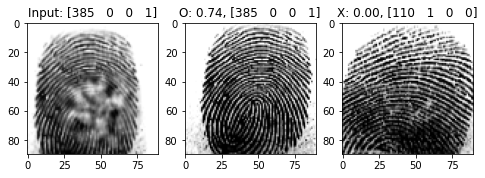

In [22]:
# new user fingerprint input
random_idx = random.randint(0, len(x_val))

# Validation data
random_img = x_val[random_idx]
random_label = label_val[random_idx]

seq = iaa.Sequential([
iaa.GaussianBlur(sigma=(0, 0.5)),
iaa.Affine(
    scale={"x": (0.9, 1.1), "y":(0.9, 1.1)},
    translate_percent={"x": (-0.1, 0.1), "y":(-0.1, 0.1)},
    rotate=(-30, 30),
    order=[0, 1],
    cval=255
)
], random_order = True)

random_img = seq.augment_image(random_img).reshape((1, 90, 90, 1)).astype(np.float32) / 255.

# matched image
match_key = random_label.astype(str)
match_key = ''.join(match_key).zfill(6) # random label

rx = x_real[label_real_dict[match_key]].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
ry = y_real[label_real_dict[match_key]]

pred_rx = model.predict([random_img, rx])

# unmatched image
unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))

ux = x_real[unmatch_idx].reshape((1, 90, 90, 1)).astype(np.float32) / 255.
uy = y_real[unmatch_idx]

pred_ux = model.predict([random_img, ux])

fig1 = plt.figure(figsize=(8, 4))
plt.subplot(1, 3, 1)
plt.title('Input: %s' %random_label)
plt.imshow(random_img.squeeze(), cmap='gray')
plt.subplot(1, 3, 2)
plt.title('O: %.02f, %s' % (pred_rx, ry))
plt.imshow(rx.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title('X: %.02f, %s' % (pred_ux, uy))
plt.imshow(ux.squeeze(), cmap='gray')


## Image Save

In [23]:
fig1.savefig(f"fig{random_idx}.png")